In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
mpl.rcParams['figure.figsize'] = (9,6)
sns.set_style('darkgrid')

## Kalman Filter Function

### _Equations_

_State Estimate Update_

$ \hat X_t = F_t X_{t-1} + B_tu_t + w_t $

_Process Cov Matrix Update_

$ \hat P_t = F_tP_{t-1}F_t^T + Q_t $

_Measurement Update_

$ Y_t = HX_t + e_t $

_Kalman Gain_

$ K = \frac{P_tH^T}{HP_tH^T + R} $

_Error in the Prediction_

$ V_t = Y_t - H_t \hat X_t $


_State Reconciliation_

$ X_t = \hat X_t + K_t V_t $

_Process Reconciliation_

$ P_t = (\hat P_t - K_tH_t \hat P_t) $

### Simulated Data

The time series generated below is a function of 3 different states (the 3 columns in `X` in code below).

The states update at each time point according to the update matrix `F`.

The actual observations are a function (`H`) of the 3 states.

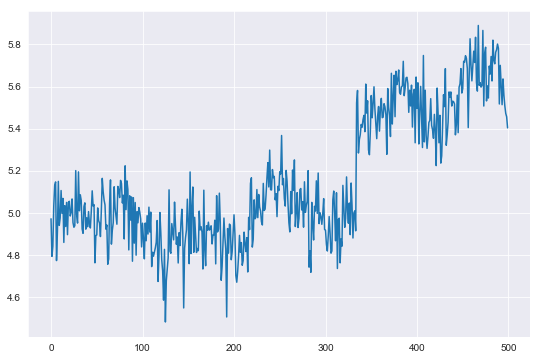

In [2]:
np.random.seed(111)

# length of the series
N = 500
pre = int(np.ceil(2*N/3)) #beginning of the treatment
postperiod = N-pre
# parameters of the state
statedim = 3
F = np.eye(statedim) # Transition matrix of state (F)
Q = 0.01*np.eye(statedim) # error (noise) in the prediction

# state values
# simulation of the state
X0 = np.array([5,0,0]) #initial conditions: mu_0=5, beta_1=0, beta_2=0
X = np.zeros((N,statedim))
X[0] = X0.dot(F) + stats.norm.rvs(loc=np.zeros((statedim)), scale=np.diag(Q))

# State update equation (for generating new state from previous state)
#+ F_tX_{t-1} + B_tu_t + w_t
#+ Here we either ommit the control variables (or assume they are part of our state???)
#+ w_t is random normal with std = Q
for i in range(1,N):
    X[i] = X[i-1].dot(F) + stats.norm.rvs(loc=np.zeros((statedim)), scale=np.diag(Q))
    
# Observation Transform Matrix (H)
# eg Y=H_tX_t + v_t
# assuming H_t is consistent through time
x1 = np.sin(2*np.pi*np.arange(1,N+1)/90) # state vector 1 (0-indexed)
x2 = np.sin(2*np.pi*np.arange(1,N+1)/360) # state vector 2

H = np.zeros((N,statedim)) 
H[:,0] = np.repeat(1,N)
H[:,1] = x1
H[:,2] = x2

# Calculate Observation From State
R = 0.01 # error/noise in the measurement
y = np.zeros(N)
for i in range(N):
    y[i] = H[i,].dot(X[i,]) + np.sqrt(R)*np.random.randn(1)

# Induce an intervention at time `pre`
e = 0.1 #effect size
ye = np.copy(y)
ye[pre:N] = y[pre:N]*(1+e)

plt.plot(ye)

X is a series of state vectors

[[ 4.98866162e+00  3.84319193e-03  1.49655378e-02]
 [ 4.98510779e+00 -4.03214348e-03  1.03711487e-02]
 [ 4.98451611e+00 -7.57387849e-03  3.01591814e-03]
 ...
 [ 4.98144836e+00  1.13333607e-01  1.03620678e-01]
 [ 4.98286722e+00  1.09471713e-01  1.03585060e-01]
 [ 4.97354207e+00  1.04481334e-01  1.01833994e-01]]


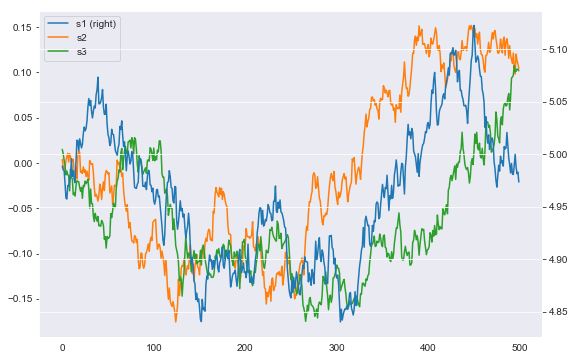

In [3]:
# each row is a time, each column represents a given component of the state.
print(X)
pd.DataFrame(X, columns = ['s1','s2','s3']).plot(secondary_y='s1')

Each subsequent row in X is a function of the previous row and the transition matrix F, plus noise

In [4]:
# so in this case just a random walk
F

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

Our actual observations are a function of the current state and the Observation Matrix H

[[ 1.          0.06975647  0.01745241]
 [ 1.          0.1391731   0.0348995 ]
 [ 1.          0.20791169  0.05233596]
 ...
 [ 1.         -0.20791169  0.66913061]
 [ 1.         -0.27563736  0.65605903]
 [ 1.         -0.34202014  0.64278761]]


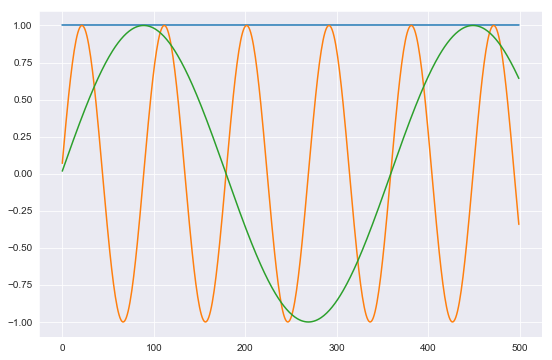

In [5]:
# the transformation of the state to our actual observation follows a fairly seasonal pattern
print(H)
plt.plot(H)

In [6]:
def kf(y, F, H, R, Q, x0, P0, B=None, u=None):
    """
    Runs data through a kalman filter.
    
    y = Observed values
    F = State Transform matrix (assumed static)
    H = Process-Measurement Transform Matrix (Kalman Gain Transform Matrix)
    R = Variance of the Measurement?
    Q = Process Covariance Noise
    x0 = initial state vector
    P0 = initial Process Cov matrix
    
    B,U = Control Matrix and variables... regressors (u) and their coefficients (B)
        # B is assumed static (for now)
        
    Returns
        Final State Matrix
        Process Covariance Matrix
    """
    N = len(y)
    ndim = len(x0)
    
    if isinstance(R, (float, int)):
        R = np.array([[R]])
    if isinstance(Q, (float, int)):
        Q = np.array([[Q]])
    
    # Controls/Covarates
    if isinstance(u, (np.ndarray, list, tuple)):
        assert B, 'Must pass control transform matrix (B) if passing control variables'
        assert len(u)  == len(y), "controls must be same length as observed"
        u = np.asarray(u)
    else:
        B,u = 0, np.zeros_like(y)
    
    
    # Set P_prev to initial P0
    P_prev = P0
    
    # Initialize our state matrix for all time periods
    x_prev = np.zeros((N+1, ndim))
    x_curr = x_prev[1:]
    x_prev[0] = x0 # first state is x0
    
    # start KF recursions
    for i in range(N):
        # make predictions
        # x` = Fx_{t-1} + Bu_{t-1} + w
        x_prev[i] = np.dot(F,x_prev[i]) + np.dot(B,u[i])
        P_prev = np.dot(np.dot(F,P_prev),F.T) + Q
        
        
        # Calculate Observation Error (S_t)
        total_err = np.dot(H[i], P_prev).dot(H[i].T) + R
        # Calculate Prediction Error (V_t)
        epsilon = y[i] - np.dot(H[i],x_prev[i])
        # kalman gain
        kg = P_prev.dot(H[i].T).dot(np.linalg.inv(total_err))
        # update x prev and x current
        #+ X_t = X_t` + K_tV_t
        if not np.isnan(epsilon):
            x_curr[i] = x_prev[i] + np.dot(kg, epsilon)
        else:
            x_curr[i] = x_prev[i]
        x_prev[i+1] = x_curr[i]
        # update P
        # reshapes are because numpy vector dot products reshape the _2nd_ vector to a column vector (we need the 1st as col vector)
        # P_t= (I - K_tH_t)P_t`
        # P_t= P_t` - K_tH_tP_t`
        # P_t` = A_{t-1}P_prevA_t^T + Q
        P_prev = P_prev - kg.reshape(-1,1).dot(H[i].reshape(1,-1)).dot(P_prev.T)
        
        
    return x_curr, P_prev

In [7]:
# initialize state and process covariance
# Large P allows for wide range of possible values. It will quickly converge.
P0 = 10000*np.eye(statedim)
x0 = np.repeat(0,statedim)

# You can change these to adjust the sensitivity of the filter
R_filter = 0.1 # error in measurment
Q_filter = np.eye(3)*0.01 # error in the process

Xs, P_final  = kf(y[:pre],F=F,H=H[:pre].reshape(pre,1,-1),R=R_filter, Q=Q_filter, x0=x0, P0=P0)

Text(0.5,1,'Results of Kalman Filter')

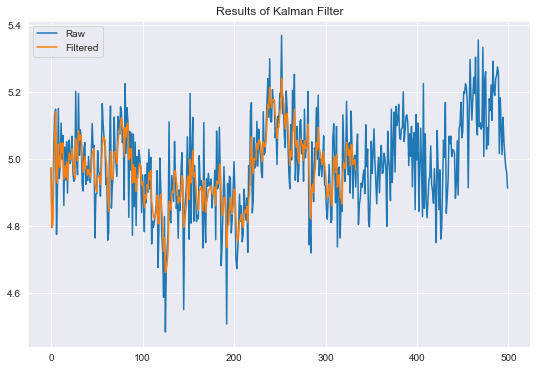

In [8]:
# apply H matrix to filtered state to get final measurments
filtered = [H[i].dot(Xs[i]) for i in range(pre)]
raw = plt.plot(y)
kf_res = plt.plot(filtered)
plt.legend([raw[0],kf_res[0]], ['Raw', 'Filtered'])
plt.title('Results of Kalman Filter')

### Single Dimension Version

In [9]:
F=np.array([1])
Q=0.01 # Error in the Process/Prediction; Controls amount of smoothing. Lower = more smoothe ()
R=0.1 # Error in the measurement; Controls amount of smoothing. Higher = more smoothe ()
P0 = np.array([1000])
x0=np.array([y[0]])

H = H[:pre,0].reshape(pre,1,-1)

X, P = kf(y[:pre], F=F, H=H, R=R, Q=Q, x0=x0, P0=P0)

array([[0.02701562]])

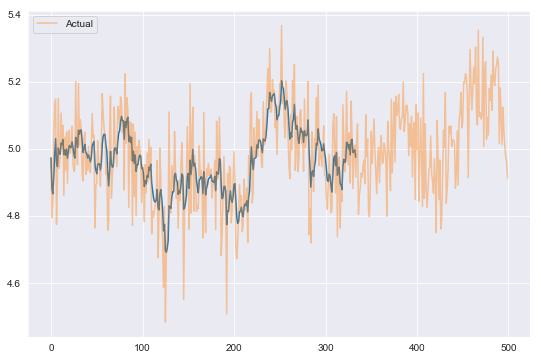

In [10]:
plt.plot(X)
plt.plot(y, alpha = 0.4, label = 'Actual')
plt.legend()
P

Add an Autoregressive Component To the Prediction

In [11]:
# AR1 model
xx = np.roll(y,1)[1:]
yx = y[1:]
slope, intr = stats.linregress(xx,yx)[0],stats.linregress(xx,yx)[1]
slope, intr

(0.45062709972559, 2.7392796914644246)

array([[1.        , 0.45050182],
       [0.45050182, 1.        ]])

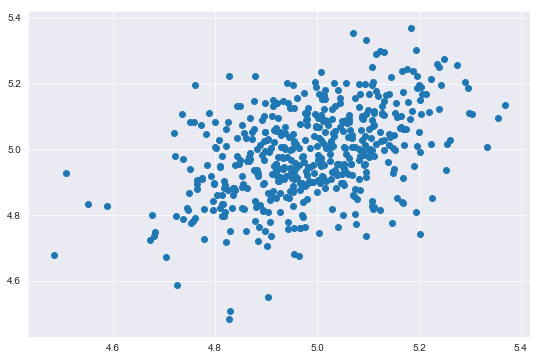

In [12]:
plt.scatter(xx,yx)
np.corrcoef(xx,yx)

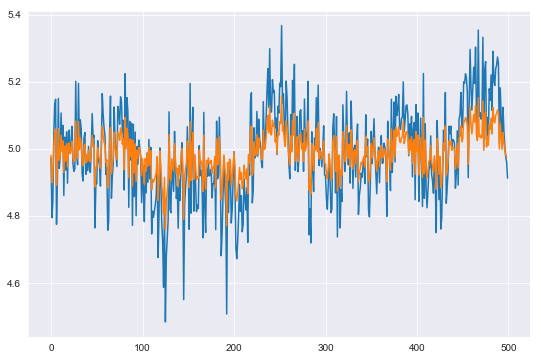

In [13]:
# Estimates from the AR1 Model Alone
plt.plot(y)
plt.plot(slope*xx + intr)

In [14]:
# Run AR1 model through the kalman filter to get smoothe estimates

F = np.array([slope]) # state updates according to the slope of the AR1 model
B = np.array([intr]) # Control matrix is the intercept
u = np.ones_like(y[:pre])

Q=0.5 # Prior for Error in the Estimate. Lower = More smoothe (aka more confidence in esitmate)
R=0.51 # Prior for error in measurement. Higher = more smoothe (aka less confidence in measurment)
P0 = np.array([1000])
x0=np.array([y[0]])

H=H[:pre,0].reshape(pre,1,-1)


X, P = kf(y[:pre], F=F, H=H, R=R, Q=Q, x0=x0, P0=P0, B=B, u=u)

array([[0.26552652]])

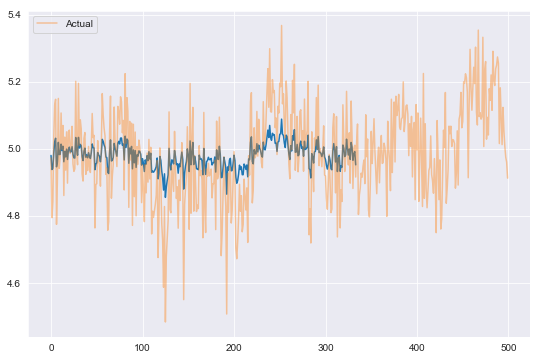

In [15]:
plt.plot(X)
plt.plot(y, alpha = 0.4, label = 'Actual')
plt.legend()
P

Introduce NaNs

In [16]:
na_idxs = np.random.randint(100, 200, 10)
y[na_idxs] = np.nan

X, P = kf(y[:pre], F=F, H=H[:pre,0], R=R, Q=Q, x0=x0, P0=P0, B=B, u=u)

array([[0.26552652]])

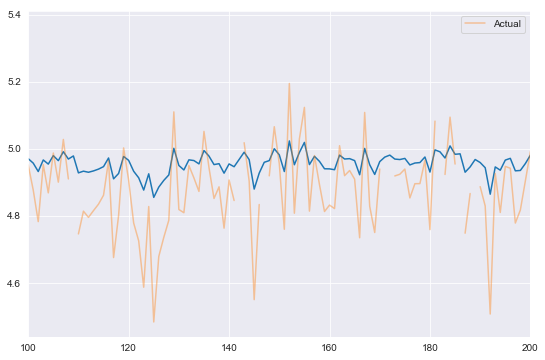

In [17]:
plt.plot(X)
plt.plot(y, alpha = 0.4, label = 'Actual')
plt.legend()
plt.xlim(100,200)
P